In [ ]:
import random
import time
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tempfile
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle

from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential, save_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install PyDrive #This Module are used to download file from google drive

In [ ]:
auth.authenticate_user() #authenticate your google account 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1NqmSuCu885NcCCfkB3aSsXcMczKhb0I8"})  #get file from google drive
downloaded.GetContentFile('imgs.zip') 

In [ ]:
!unzip -q '/content/imgs.zip'

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 1024
shuffle_size = 1000
classs = ['Doing Hair or Makeup','Drinking', 'Operating Radio', 'Reaching Behind', 'Save Driving', 'Talking On The Phone left', 'Talking On The phone Right', 'Talking to passenger', 'Texting Left', 'Texting Right']

img_directory = '/content/imgs/train'


def blur(img):
    return (cv2.GaussianBlur(img,(3,3),0))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                #rotation_range = 60,
                                                                zoom_range = 0.5,
                                                                horizontal_flip= True,
                                                                fill_mode = 'nearest',
                                                                preprocessing_function=blur,
                                                                validation_split=0.2)
   
    
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
     '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    seed = 100,
    shuffle=True)


val_generator = valid_datagen.flow_from_directory(
   '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    subset='validation',
    shuffle=True)


test_generator = test_datagen.flow_from_directory(
   '/content/imgs/test', #change it into your test directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    classes = classs,
    class_mode="categorical",
    shuffle=False)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 0 images belonging to 10 classes.


In [ ]:
augmented_images = [train_generator[0][0][0] for i in range (5)]

In [ ]:
def PlotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show

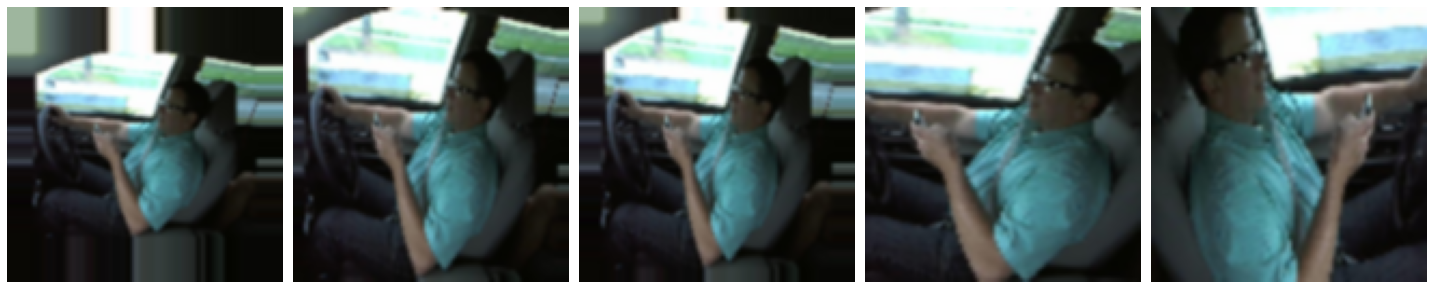

In [ ]:
PlotImages(augmented_images)

In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #Print the batch size and labels.

((1024, 128, 128, 3), (1024, 10))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Doing Hair or Makeup': 0, 'Drinking': 1, 'Operating Radio': 2, 'Reaching Behind': 3, 'Save Driving': 4, 'Talking On The Phone left': 5, 'Talking On The phone Right': 6, 'Talking to passenger': 7, 'Texting Left': 8, 'Texting Right': 9}


In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

mobnet = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                        include_top=False, 
                                         weights='imagenet')
mobnet.trainable=False

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model2 = tf.keras.Sequential([
  mobnet,
  tf.keras.layers.Conv2D(1024, 3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_aug.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 1024)        9438208   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 12,677,322
Trainable params: 9,448,458
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history1 = model2.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=100, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

NameError: ignored

In [ ]:
def plot_train_history(history1):
    # Summarize history for accuracy
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

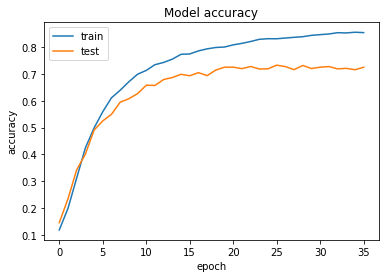

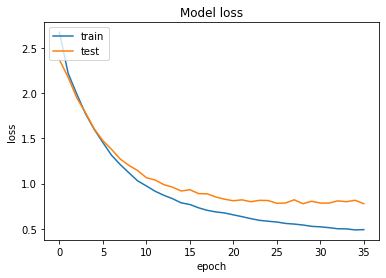

In [ ]:
plot_train_history(history1)


In [ ]:
mobnet.trainable = True
print("Number of layers in the base model: ", len(mobnet.layers))

Number of layers in the base model:  87


In [ ]:
fine_tune_at = 77
for layer in mobnet.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_aug.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 1024)        9438208   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 1024)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 12,677,322
Trainable params: 11,036,682
Non-trainable params: 1,640,640
_________________________________________________________________


In [ ]:
labels = (train_generator.class_indices)
evaluate = model2.evaluate(test_generator,labels, steps=24)
print('Accuracy: %.2f%%' % (evaluate[1]*100))

ValueError: ignored

In [ ]:
model=tf.keras.models.load_model("./mobnet_wo_ft.hdf5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)  

OSError: ignored

In [ ]:
history_fine = model2.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=100, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 0.8417 - accuracy: 0.7193
Epoch 00001: val_loss improved from inf to 1.33958, saving model to mobnet_aug.hdf5
18/18 [==============================] - 146s 8s/step - loss: 0.8417 - accuracy: 0.7193 - val_loss: 1.3396 - val_accuracy: 0.5724
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7800
Epoch 00002: val_loss improved from 1.33958 to 1.10111, saving model to mobnet_aug.hdf5
18/18 [==============================] - 144s 8s/step - loss: 0.6553 - accuracy: 0.7800 - val_loss: 1.1011 - val_accuracy: 0.6086
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.8017
Epoch 00003: val_loss did not improve from 1.10111
18/18 [==============================] - 144s 8s/step - loss: 0.5980 - accuracy: 0.8017 - val_loss: 1.1343 - val_accuracy: 0.6008
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.8149
Epoch 0

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

mobnetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                        include_top=False, 
                                         weights='imagenet')
mobnetv2.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model3 = tf.keras.Sequential([
  mobnetv2,
  tf.keras.layers.Conv2D(1024, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_aug.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 1024)        11797504  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 14,065,738
Trainable params: 11,807,754
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history3 = model3.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=100, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 2.1366 - accuracy: 0.2498
Epoch 00001: val_loss improved from inf to 2.03700, saving model to mobnet_aug.hdf5
36/36 [==============================] - 319s 9s/step - loss: 2.1366 - accuracy: 0.2498 - val_loss: 2.0370 - val_accuracy: 0.2774
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.5573 - accuracy: 0.5043
Epoch 00002: val_loss improved from 2.03700 to 1.84888, saving model to mobnet_aug.hdf5
36/36 [==============================] - 322s 9s/step - loss: 1.5573 - accuracy: 0.5043 - val_loss: 1.8489 - val_accuracy: 0.3519
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.6111
Epoch 00003: val_loss improved from 1.84888 to 1.64030, saving model to mobnet_aug.hdf5
36/36 [==============================] - 319s 9s/step - loss: 1.2668 - accuracy: 0.6111 - val_loss: 1.6403 - val_accuracy: 0.4251
Epoch 4/100
36/36 [==============================] - ETA: 0s - lo

In [ ]:
model4 = tf.keras.Sequential([
  mobnet,
  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_aug_smaller.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 512)         4719104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 7,953,098
Trainable params: 4,724,234
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history3 = model4.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=100, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 1.4276 - accuracy: 0.5354
Epoch 00001: val_loss improved from 0.64802 to 0.56930, saving model to mobnet_aug_smaller.hdf5
24/24 [==============================] - 263s 11s/step - loss: 1.4276 - accuracy: 0.5354 - val_loss: 0.5693 - val_accuracy: 0.8670
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.6244 
Epoch 00002: val_loss did not improve from 0.56930
24/24 [==============================] - 265s 11s/step - loss: 1.1482 - accuracy: 0.6244 - val_loss: 0.5766 - val_accuracy: 0.8538
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.6785
Epoch 00003: val_loss improved from 0.56930 to 0.55941, saving model to mobnet_aug_smaller.hdf5
24/24 [==============================] - 266s 11s/step - loss: 1.0056 - accuracy: 0.6785 - val_loss: 0.5594 - val_accuracy: 0.8547
Epoch 00003: early stopping
